# Clustering Traffic Incident Data in the UAE Using K-Means and DBSCAN with Cross-Validation and Silhouette Scoring

## Importing Libraries

In [85]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from datetime import datetime

# Set up consistent plot styling
sns.set(style="whitegrid")


## Load and Preprocess the Data

In [5]:
# Load the dataset
data = pd.read_csv('Traffic_Incidents.csv')

# Preview the dataset
data.head()

,acci_id,acci_time,acci_name,acci_x,acci_y
0,6098035734,08/12/2024 17:26:50,صدم حاجز - بسيط,25.100000,55.373886
1,6098067292,08/12/2024 17:57:59,مركبه عطلانه في الشارع - بسيط,25.249974,55.281985
2,6098074482,08/12/2024 18:05:08,تدهور مركبة ثقيلة - بسيط,25.226530,55.357353
3,6098078723,08/12/2024 18:08:34,دهس - بليغ,25.041388,55.143890
4,6098109434,08/12/2024 18:37:18,صدم حاجز - بسيط,25.125350,55.153500


## Data Preprocessing

In [8]:
# Convert 'acci_time' to datetime
data['acci_time'] = pd.to_datetime(data['acci_time'], format='%d/%m/%Y %H:%M:%S')

# Extract relevant time features
data['hour'] = data['acci_time'].dt.hour
data['day'] = data['acci_time'].dt.day
data['month'] = data['acci_time'].dt.month
data['date'] = data['acci_time'].dt.date

# Select relevant columns for clustering
geo_data = data[['acci_x', 'acci_y']]

# Remove rows with zero coordinates (if any)
geo_data = geo_data[(geo_data['acci_x'] != 0) & (geo_data['acci_y'] != 0)]

# Standardize the coordinates for clustering
scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo_data)


## Special Event Dates Analysis

In [95]:
# List of special event dates for 2024
special_event_dates = [
    '01/01/2024', '01/05/2024', '02/12/2024', '01/12/2024', '06/07/2024',
    '15/09/2024', '09/04/2024', '06/06/2024', '05/06/2024', '03/11/2024', '13/02/2024'
]

# Convert special event dates to datetime and extract the date part
special_event_dates = pd.to_datetime(special_event_dates, format='%d/%m/%Y').date

# Add a column indicating whether the date is a special event
merged_data['special_event'] = merged_data['date'].apply(lambda x: 1 if x in special_event_dates else 0)

# Calculate the correlation between incident_count and special_event
correlation = merged_data['incident_count'].corr(merged_data['special_event'])
print("Correlation between special events and number of incidents:", correlation)
merged_data[0:10]

Correlation between special events and number of incidents: -0.036225645336301515


,date,incident_count,special_event
0,2024-12-08,242,0
1,2024-12-07,322,0
2,2024-12-06,295,0
3,2024-12-05,346,0
4,2024-12-04,283,0
5,2024-12-03,238,0
6,2024-12-02,246,1
7,2024-12-01,293,1
8,2024-11-30,370,0
9,2024-11-29,334,0


#### Visualizing Incident Counts on Special Event vs Regular Days

C:\Users\faroo\AppData\Local\Temp\ipykernel_5556\152126980.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([merged_data[merged_data['special_event'] == 1]['incident_count'],


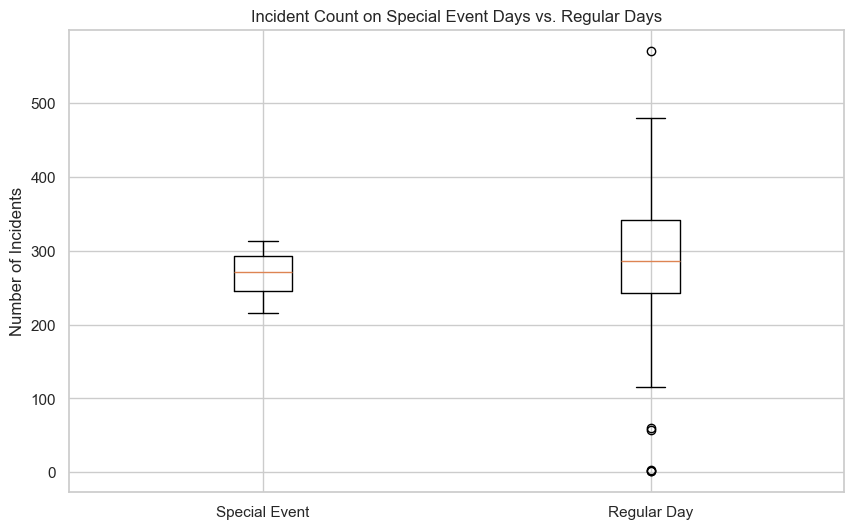

In [103]:
# Boxplot of incidents on special event days vs. regular days
plt.figure(figsize=(10, 6))
plt.boxplot([merged_data[merged_data['special_event'] == 1]['incident_count'],
             merged_data[merged_data['special_event'] == 0]['incident_count']],
            labels=['Special Event', 'Regular Day'])
plt.title('Incident Count on Special Event Days vs. Regular Days')
plt.ylabel('Number of Incidents')
plt.show()


## Time-based Features and Incident Analysis

In [12]:
# Count the number of incidents for each day
incident_counts = data.groupby('date').size().reset_index(name='incident_count')

# Merge with unique dates to ensure all dates are included
unique_dates = pd.DataFrame(data['date'].unique(), columns=['date'])
merged_data = pd.merge(unique_dates, incident_counts, on='date', how='left')

# Fill NaN values (dates with no incidents) with 0
merged_data['incident_count'].fillna(0, inplace=True)

# Display the resulting DataFrame
merged_data.head()


C:\Users\faroo\AppData\Local\Temp\ipykernel_5556\3468117358.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['incident_count'].fillna(0, inplace=True)


,date,incident_count
0,2024-12-08,242
1,2024-12-07,322
2,2024-12-06,295
3,2024-12-05,346
4,2024-12-04,283


### Hourly Incident Counts Analysis

Hourly Incident Counts:
    hour  incident_count
0      0            1826
1      1            1441
2      2            1097
3      3             936
4      4             815
5      5             965
6      6            1418
7      7            1811
8      8            2198
9      9            2466
10    10            2623
11    11            2838
12    12            2993
13    13            3296
14    14            3565
15    15            3446
16    16            3261
17    17            3141
18    18            3024
19    19            2888
20    20            2870
21    21            2788
22    22            2453
23    23            1736
Correlation between hour of the day and number of incidents: 0.6717128585795085


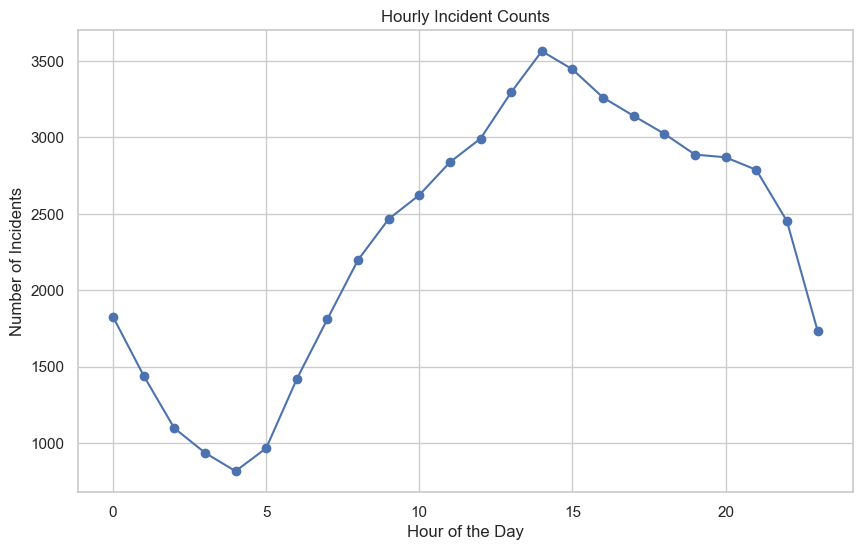

In [24]:
# Count the number of incidents for each hour of the day
hourly_incident_counts = data.groupby('hour').size().reset_index(name='incident_count')

# Display the hourly incident counts
print("Hourly Incident Counts:")
print(hourly_incident_counts)

# Calculate the correlation between hour and number of incidents
correlation_hour_incidents = hourly_incident_counts['hour'].corr(hourly_incident_counts['incident_count'])
print(f"Correlation between hour of the day and number of incidents: {correlation_hour_incidents}")

# Visualize hourly incident counts
plt.figure(figsize=(10, 6))
plt.plot(hourly_incident_counts['hour'], hourly_incident_counts['incident_count'], marker='o')
plt.title('Hourly Incident Counts')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()


#### Hourly Incident Counts and Regression

Mean Squared Error (Linear Regression): 261947.4072415214
R-squared (Linear Regression): 0.08390727489558147


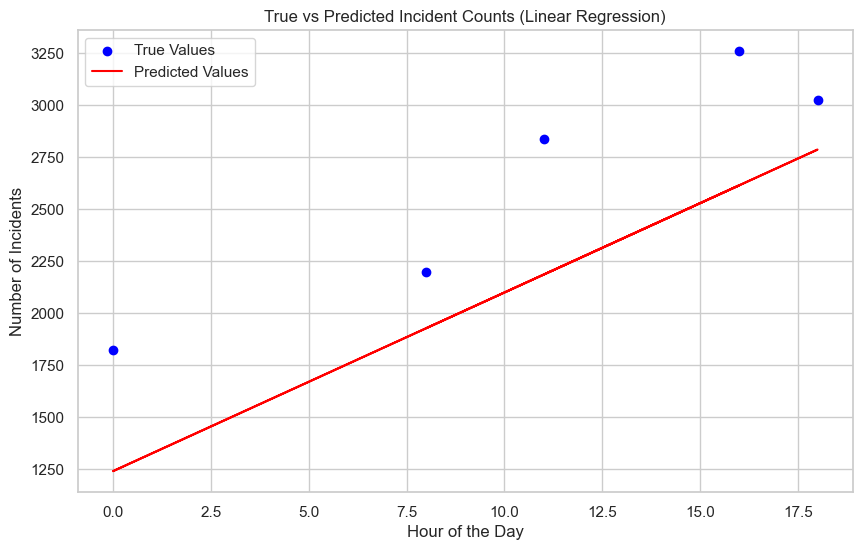

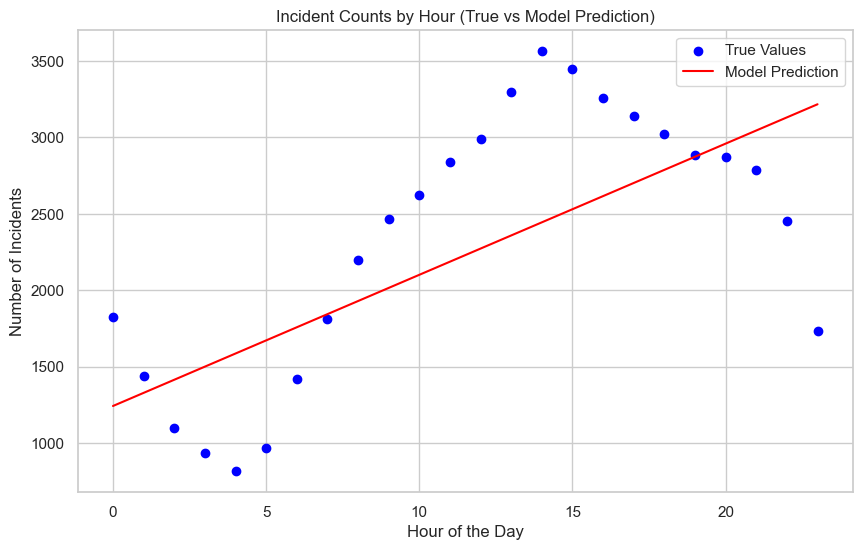

In [108]:
# Features (X) and target (y)
X = hourly_incident_counts[['hour']]  # Feature: hour of the day
y = hourly_incident_counts['incident_count']  # Target: number of incidents

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (Linear Regression): {mse}")
print(f"R-squared (Linear Regression): {r2}")

# Visualize the true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='True Values')
plt.plot(X_test, y_pred, color='red', label='Predicted Values')
plt.title('True vs Predicted Incident Counts (Linear Regression)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the model's performance across all hours
plt.figure(figsize=(10, 6))
plt.scatter(hourly_incident_counts['hour'], hourly_incident_counts['incident_count'], color='blue', label='True Values')
plt.plot(hourly_incident_counts['hour'], model.predict(hourly_incident_counts[['hour']]), color='red', label='Model Prediction')
plt.title('Incident Counts by Hour (True vs Model Prediction)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.legend()
plt.grid(True)
plt.show()

#### K-Fold Cross Validation with K-Nearest Neighbors Regression

Mean Squared Error (KNN with K-Fold CV): 181979.33400000003
R-squared (KNN): 0.9211372006184457
Mean Squared Error (MSE) (KNN): 57429.99666666667


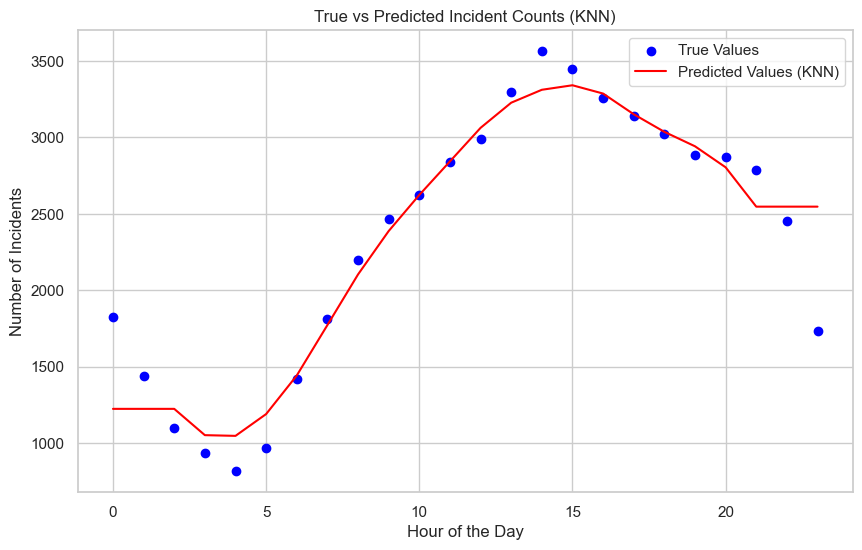

In [90]:
# Initialize the K-Nearest Neighbors model
knn = KNeighborsRegressor()

# Perform K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = cross_val_score(knn, X, y, cv=kf, scoring='neg_mean_squared_error')

# Calculate the Mean Squared Error for each fold
mean_mse_knn = -cross_val_results.mean()
print(f"Mean Squared Error (KNN with K-Fold CV): {mean_mse_knn}")

# Train the KNN model on the full dataset
knn.fit(X, y)

# Make predictions
y_pred_knn = knn.predict(X)

# Evaluate the model
r2_knn = r2_score(y, y_pred_knn)
mse_knn = mean_squared_error(y, y_pred_knn)

print(f"R-squared (KNN): {r2_knn}")
print(f"Mean Squared Error (MSE) (KNN): {mse_knn}")

# Visualize the true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='True Values')
plt.plot(X, y_pred_knn, color='red', label='Predicted Values (KNN)')
plt.title('True vs Predicted Incident Counts (KNN)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.legend()
plt.grid(True)
plt.show()


## Feature Correlation Heatmap

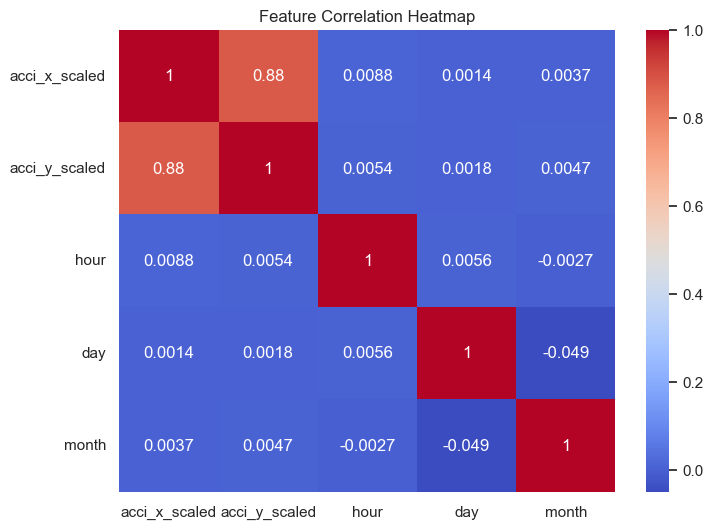

In [27]:
# Standardize the coordinates for clustering
data[['acci_x_scaled', 'acci_y_scaled']] = scaler.fit_transform(data[['acci_x', 'acci_y']])

# Select features for unsupervised learning
features = data[['acci_x_scaled', 'acci_y_scaled', 'hour', 'day', 'month']]

# Display correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(features.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


## K-Means Clustering

Optimal number of clusters (k): 2


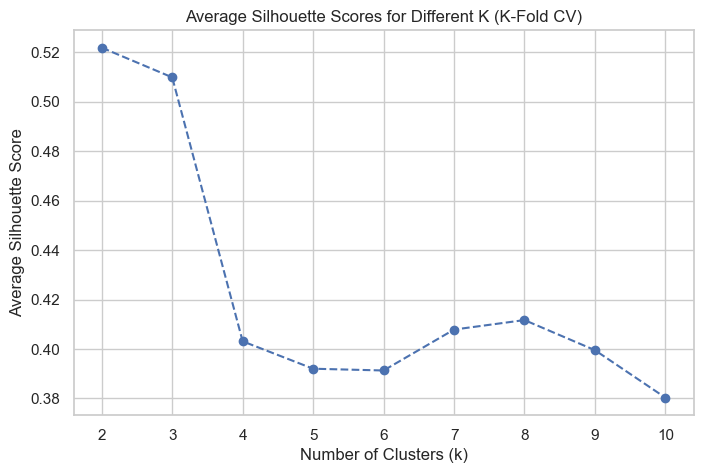

In [34]:
# Ensure the data has been preprocessed, e.g., valid coordinates and scaled data
# Filter rows with invalid coordinates (if any)
valid_rows = (data['acci_x'] != 0) & (data['acci_y'] != 0)
data_filtered = data[valid_rows].reset_index(drop=True)
geo_data = data_filtered[['acci_x', 'acci_y']]

# Standardize the data for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo_data)

# K-Fold Cross-Validation to Find Optimal K
k_folds = 5  # Number of folds for cross-validation
range_clusters = range(2, 11)  # Range of clusters to evaluate (you can adjust this)
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Dictionary to store average silhouette scores for each k
silhouette_scores = {k: [] for k in range_clusters}

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(geo_scaled):
    X_train, X_test = geo_scaled[train_index], geo_scaled[test_index]
    
    for k in range_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_train)
        # Compute silhouette score for the current fold and k
        score = silhouette_score(X_test, kmeans.predict(X_test))
        silhouette_scores[k].append(score)

# Calculate the average silhouette scores across folds
avg_silhouette_scores = {k: np.mean(scores) for k, scores in silhouette_scores.items()}

# Find the optimal number of clusters (k) with the highest average silhouette score
optimal_k = max(avg_silhouette_scores, key=avg_silhouette_scores.get)
print(f"Optimal number of clusters (k): {optimal_k}")

# Plot Average Silhouette Scores
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, avg_silhouette_scores.values(), marker='o', linestyle='--', color='b')
plt.title("Average Silhouette Scores for Different K (K-Fold CV)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

#### Perform K-Means with the Optimal K


Silhouette Score for K-Means (k=2): 0.52


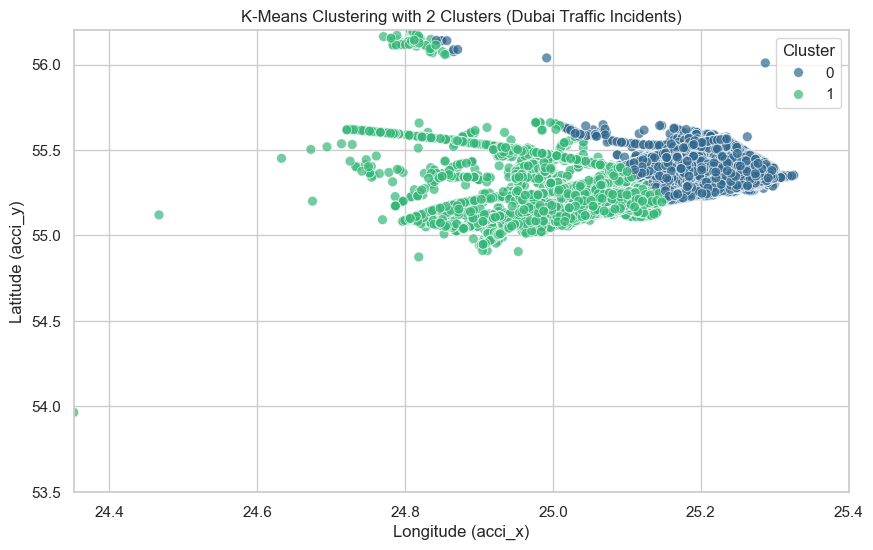

In [38]:
# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(geo_scaled)

# Add the labels to the filtered data for visualization
data_filtered['KMeans_Cluster'] = kmeans_labels

# Calculate silhouette score for K-Means (on the whole dataset)
kmeans_silhouette = silhouette_score(geo_scaled, kmeans_labels)
print(f"Silhouette Score for K-Means (k={optimal_k}): {kmeans_silhouette:.2f}")

# Visualize K-Means Clustering Results
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=geo_data['acci_x'], 
    y=geo_data['acci_y'], 
    hue=kmeans_labels, 
    palette="viridis", 
    s=50, 
    alpha=0.7
)
plt.title(f"K-Means Clustering with {optimal_k} Clusters (Dubai Traffic Incidents)")
plt.xlabel("Longitude (acci_x)")
plt.ylabel("Latitude (acci_y)")

# Set geographic limits based on Dubai's coordinates
plt.xlim(24.35207198, 25.4)  # Longitude range for Dubai
plt.ylim(53.5, 56.20201)  # Latitude range for Dubai

# Display the legend
plt.legend(title="Cluster", loc="upper right")

# Show the plot
plt.show()


## DBSCAN Clustering

In [42]:
# Ensure consistent filtering between geo_data and data
valid_rows = (data['acci_x'] != 0) & (data['acci_y'] != 0)
data_filtered = data[valid_rows].reset_index(drop=True)
geo_data = data_filtered[['acci_x', 'acci_y']]

# Standardize the data for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo_data)

# Perform DBSCAN Clustering
dbscan = DBSCAN(eps=0.2, min_samples=10)  # Adjust parameters as needed
dbscan_labels = dbscan.fit_predict(geo_scaled)

# Ensure the length of labels matches the length of filtered data
if len(dbscan_labels) != len(data_filtered):
    raise ValueError("Mismatch between DBSCAN labels and data rows.")

# Add DBSCAN labels to the filtered dataset
data_filtered['DBSCAN_Cluster'] = dbscan_labels

# Calculate silhouette score for DBSCAN (excluding noise points labeled as -1)
if len(np.unique(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(
        geo_scaled[dbscan_labels != -1], 
        dbscan_labels[dbscan_labels != -1]
    )
else:
    dbscan_silhouette = float('nan')

print(f"Silhouette Score for DBSCAN: {dbscan_silhouette:.2f}")

Silhouette Score for DBSCAN: 0.49


## Visualize K-Means and DBSCAN Clustering Results

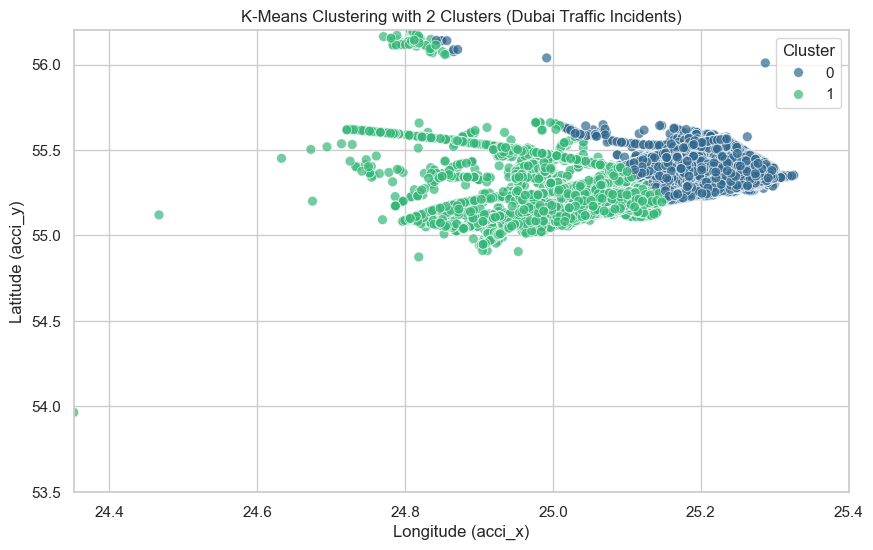

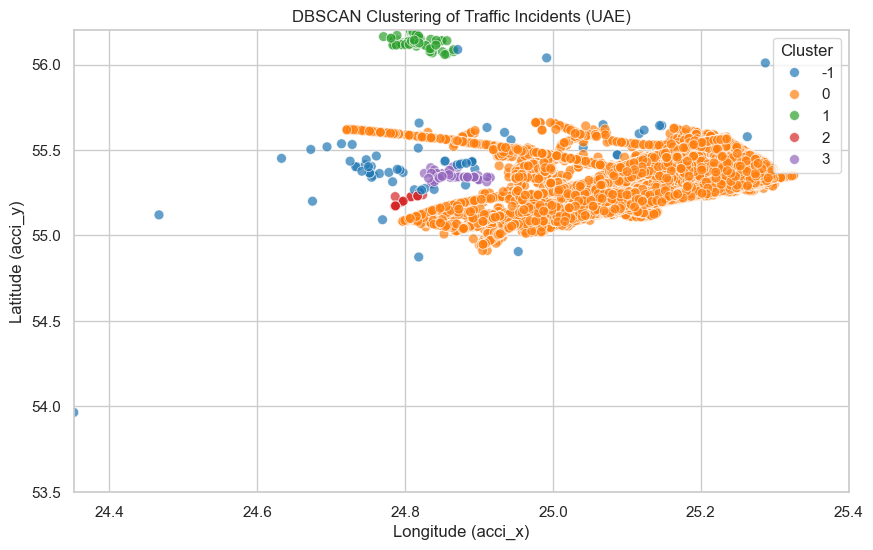

In [48]:
# K-Means Clustering Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=geo_data['acci_x'], 
    y=geo_data['acci_y'], 
    hue=kmeans_labels, 
    palette="viridis", 
    s=50, 
    alpha=0.7
)
plt.title(f"K-Means Clustering with {optimal_k} Clusters (Dubai Traffic Incidents)")
plt.xlabel("Longitude (acci_x)")
plt.ylabel("Latitude (acci_y)")
plt.xlim(24.35207198, 25.4)  
plt.ylim(53.5, 56.20201)  
plt.legend(title="Cluster", loc="upper right")
plt.show()

# DBSCAN Clustering Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=geo_data['acci_x'], 
    y=geo_data['acci_y'], 
    hue=dbscan_labels, 
    palette="tab10", 
    s=50, 
    alpha=0.7
)
plt.title("DBSCAN Clustering of Traffic Incidents (UAE)")
plt.xlabel("Longitude (acci_x)")
plt.ylabel("Latitude (acci_y)")
plt.xlim(24.35207198, 25.4) 
plt.ylim(53.5, 56.20201)  
plt.legend(title="Cluster", loc="upper right")
plt.show()
